# Collaboration and Competition

---

In this notebook, I will train a MADDPG model using Unity ML environment.

### 1. Start the Environment

Run the next code cell to install a few packages(if you haven't already). This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from agent import Agent

# select this if you are running the reacher app on any cloud based VM(AWS, GCP, etc.)
env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

# select this if you are running the reacher app on your local machine(windows)
#env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Each agent receives its own, local observation. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Train the Agent

**important note**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```


In [5]:
agent1 = Agent(state_size, action_size, 1, random_seed=0)
agent2 = Agent(state_size, action_size, 1, random_seed=0)

In [6]:
episodes = 2000
scores_window = deque(maxlen=100)
scores_all = []
averages = []

for episode in range(episodes):
    env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
    states = env_info.vector_observations
    states = np.reshape(states, (1,48))
    agent1.reset()
    agent2.reset()
    scores = np.zeros(num_agents)
    while True:
        action1 = agent1.act(states)           # agent 1 chooses an action
        action2 = agent2.act(states)           # agent 2 chooses an action
        # concatenate the actions and reshape them for the environment
        actions = np.reshape(np.concatenate((action1, action2), axis=0),(1,4)) 
        # send both agents' actions together to the environment
        env_info = env.step(actions)[brain_name]
        # get next states and reshape them 
        next_states = np.reshape(env_info.vector_observations,(1,48))         
        rewards = env_info.rewards                         # get reward
        done = env_info.local_done                         # see if episode finished
        agent1.step(states, actions, rewards[0], next_states, done, 0) # train agent 1
        agent2.step(states, actions, rewards[1], next_states, done, 1) # train agent 2
        
        
        scores += rewards                                  # update the score for each agent
        states = next_states                               # roll over states to next time step

        if np.any(done):                                  
            break

    max_score = np.max(scores)
    scores_window.append(max_score)
    scores_all.append(max_score)
    averages.append(np.mean(scores_window))
    # print training progression every now and then            
    if episode % 50 == 0:
        print('Episode {}\tMax Reward: {:.2f}\tAverage Reward: {:.3f}'.format(
            episode, max_score, np.mean(scores_window)))
    # check if we have reached the solved condition
    # if yes, print results and save agent networks weights for later use
    # and exit the training cycle
    if np.mean(scores_window)>=0.5:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(
            episode, np.mean(scores_window)))
        torch.save(agent1.actor_local.state_dict(), 'checkpoint_actor1.pth')
        torch.save(agent1.critic_local.state_dict(), 'checkpoint_critic1.pth')
        torch.save(agent2.actor_local.state_dict(), 'checkpoint_actor2.pth')
        torch.save(agent2.critic_local.state_dict(), 'checkpoint_critic2.pth')
        break

Episode 0	Max Reward: 0.00	Average Reward: 0.000
Episode 50	Max Reward: 0.00	Average Reward: 0.002
Episode 100	Max Reward: 0.00	Average Reward: 0.009
Episode 150	Max Reward: 0.00	Average Reward: 0.015
Episode 200	Max Reward: 0.10	Average Reward: 0.019
Episode 250	Max Reward: 0.00	Average Reward: 0.025
Episode 300	Max Reward: 0.10	Average Reward: 0.033
Episode 350	Max Reward: 0.00	Average Reward: 0.041
Episode 400	Max Reward: 0.00	Average Reward: 0.046
Episode 450	Max Reward: 0.00	Average Reward: 0.047
Episode 500	Max Reward: 0.10	Average Reward: 0.063
Episode 550	Max Reward: 0.10	Average Reward: 0.085
Episode 600	Max Reward: 0.20	Average Reward: 0.092
Episode 650	Max Reward: 0.10	Average Reward: 0.097
Episode 700	Max Reward: 0.10	Average Reward: 0.111
Episode 750	Max Reward: 0.10	Average Reward: 0.119
Episode 800	Max Reward: 0.10	Average Reward: 0.133
Episode 850	Max Reward: 0.10	Average Reward: 0.149
Episode 900	Max Reward: 0.40	Average Reward: 0.212
Episode 950	Max Reward: 0.30	Avera

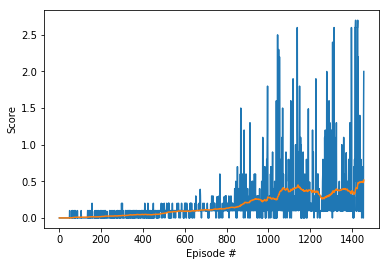

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_all)+1), scores_all)
plt.plot(np.arange(1, len(averages)+1), averages)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Watch the agent play!

In [ ]:
agent1.actor_local.load_state_dict(torch.load('checkpoint_actor1.pth', map_location={'cuda:0': 'cpu'}))
agent1.critic_local.load_state_dict(torch.load('checkpoint_critic1.pth', map_location={'cuda:0': 'cpu'}))
agent2.actor_local.load_state_dict(torch.load('checkpoint_actor2.pth', map_location={'cuda:0': 'cpu'}))
agent2.critic_local.load_state_dict(torch.load('checkpoint_critic2.pth', map_location={'cuda:0': 'cpu'}))

env_info = env.reset(train_mode=False)[brain_name]        
states = env_info.vector_observations
states = np.reshape(states, (1,48))                 
scores = np.zeros(num_agents)         

        
for i in range(200):
    action1 = agent1.act(states, add_noise=False)           # agent 1 chooses an action
    action2 = agent2.act(states, add_noise=False)           # agent 2 chooses an action
    # concatenate the actions and reshape them for the environment
    actions = np.reshape(np.concatenate((action1, action2), axis=0),(1,4)) 
    # send both agents' actions together to the environment
    env_info = env.step(actions)[brain_name]
    # get next states and reshape them 
    next_states = np.reshape(env_info.vector_observations,(1,48))         
    rewards = env_info.rewards                         # get reward
    done = env_info.local_done                         # see if episode finished
    scores += rewards                                  # update the score for each agent
    states = next_states                               # roll over states to next time step
    #if np.any(done):                                  
           # break

In [11]:
env.close()